<a href="https://colab.research.google.com/github/ripandeep1750/News_Popularity_Analysis/blob/main/online-news-popularity-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

In [ ]:
# Import necessary libraries
import numpy as np  # For numerical operations and linear algebra
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced data visualization
from copy import copy  # For copying objects
from sklearn.manifold import TSNE  # For dimensionality reduction and visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/nytpopular.csv")
data.head(n=4)

,id,retweet_count,reply_count,like_count,url,date,bag_of_phrases
0,1512064169222287361,723,168,2974,https://nyti.ms/3KkLZrK,2022-04-07 09:46:05-04:00,"['$', '42', '46', 'accord', 'aim', 'antiquity'..."
1,1488331283226894340,42,16,139,https://nyti.ms/3rfxPAS,2022-01-31 21:00:04-05:00,"['2003', '2015', '2018', '2030', '20_percent',..."
2,1510781717744914441,24,16,245,https://nyti.ms/3NKR4Mc,2022-04-03 20:50:05-04:00,"['2020', '6', '6_2021', 'adjust', 'album', 'an..."
3,1483514600406540288,56,22,237,https://nyti.ms/3IhrsTk,2022-01-18 14:00:17-05:00,"[' ', '$', '$_1.2', '$_1.4', '$_1.5', '$_1.6',..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9100 entries, 0 to 9099
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              9100 non-null   int64 
 1   retweet_count   9100 non-null   int64 
 2   reply_count     9100 non-null   int64 
 3   like_count      9100 non-null   int64 
 4   url             9100 non-null   object
 5   date            9100 non-null   object
 6   bag_of_phrases  9100 non-null   object
dtypes: int64(4), object(3)
memory usage: 497.8+ KB


In [ ]:
# Dropping irrelevant columns
columns_to_drop = ['url', 'date', 'bag_of_phrases']
data.drop(labels=columns_to_drop, axis=1, inplace=True)

# Displaying modified data
print("First four rows after dropping columns:")
print(data.head(n=4))

# Creating a copy of the original data
original_data = data.copy()

First four rows after dropping columns:
                    id  retweet_count  reply_count  like_count
0  1512064169222287361            723          168        2974
1  1488331283226894340             42           16         139
2  1510781717744914441             24           16         245
3  1483514600406540288             56           22         237


In [ ]:
data.describe()

,id,retweet_count,reply_count,like_count
count,9.100000e+03,9100.000000,9100.000000,9100.000000
mean,1.496276e+18,204.552418,92.086264,834.303956
std,1.085665e+16,653.673622,240.699649,2686.369570
min,1.477067e+18,0.000000,0.000000,0.000000
25%,1.487142e+18,38.000000,21.000000,159.000000
50%,1.496230e+18,72.000000,39.000000,285.000000
75%,1.505626e+18,157.000000,82.000000,627.000000
max,1.515445e+18,20463.000000,8473.000000,116847.000000


In [ ]:
like_data = np.sort(data['like_count'].values)
print(like_data.shape)
leng = like_data.shape[0]

(9100,)


In [ ]:
middle = like_data[int(leng*0.5)-1]
middle

285

In [ ]:
like_label = list()
for like in data['like_count']:
    if like <= 285:
        like_label.append('Unpopular')
    else:
        like_label.append('Popular')

In [ ]:
# Update this class label into the dataframe
data = pd.concat([data.reset_index(drop=True), pd.DataFrame(like_label, columns=['popularity'])], axis=1)
data.head(4)

,id,retweet_count,reply_count,like_count,popularity
0,1512064169222287361,723,168,2974,Popular
1,1488331283226894340,42,16,139,Unpopular
2,1510781717744914441,24,16,245,Unpopular
3,1483514600406540288,56,22,237,Unpopular


,popularity,No of articles
0,Popular,4547
1,Unpopular,4553


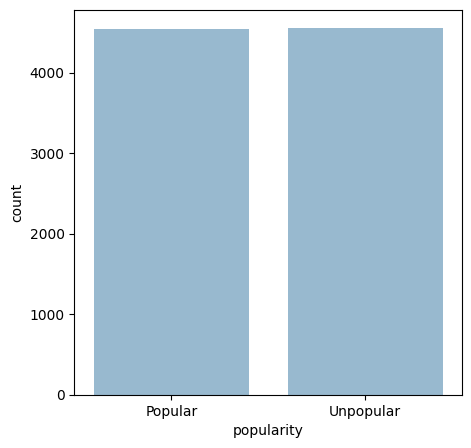

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='popularity',data=data,alpha=0.5)
data_channel_data = data.groupby('popularity').size().reset_index()
data_channel_data.columns = ['popularity','No of articles']
data_channel_data

In [ ]:
print("Skewness: %f" % data['like_count'].skew())
print("Kurtosis: %f" % data['like_count'].kurt())

Skewness: 18.154914
Kurtosis: 545.682417


<ipython-input-14-11c0bea7b489>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['like_count'], fit=norm);


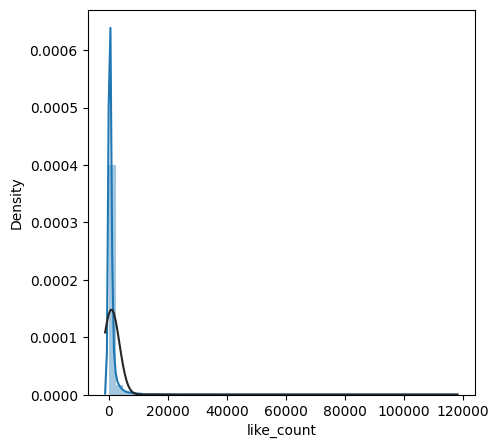

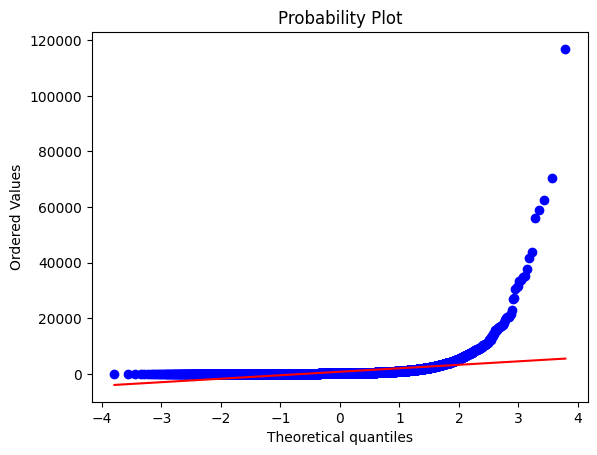

In [ ]:
from scipy.stats import norm, probplot
# Filtering out extreme values for better visualization
temp_data = data[data['like_count'] <= 100000]

# Creating subplots for histogram and probability plot
fig,ax = plt.subplots(figsize=(5,5))

# Histogram
sns.distplot(data['like_count'], fit=norm);

# Normal probability plot
fig = plt.figure()
res = probplot(data['like_count'], plot=plt)

<ipython-input-15-9455f4956b16>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_like_log, fit=norm);


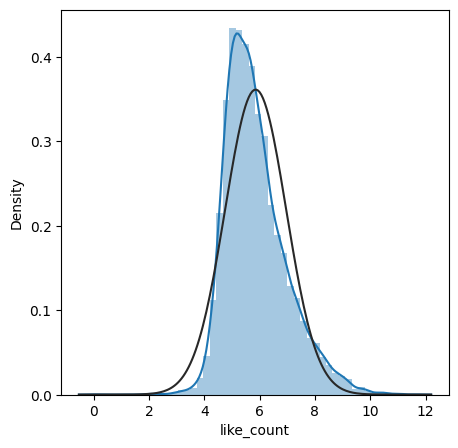

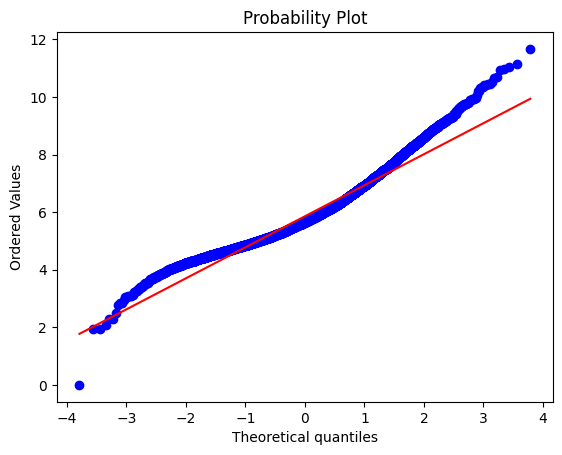

In [ ]:
#applying log transformation
new_like_data = copy(data)
new_like_data.loc[new_like_data['like_count'] > 0, 'like_count'] = np.log(data.loc[data['like_count'] > 0, 'like_count'])
new_like_log = new_like_data['like_count']

# Transformed Histogram
fig,ax = plt.subplots(figsize=(5,5))
sns.distplot(new_like_log, fit=norm);

# Transformed Normal Probability Plot
fig = plt.figure()
res = probplot(new_like_log, plot=plt)

In [ ]:
for col in data.iloc[:,:-1].columns:
    # Check if any value in the column is zero
    if (data[col] <= 0).any():
        print(f"Skipping log transformation for column '{col}' because it contains zero or negative values.")
    else:
        # Applying log transformation
        data[col] = np.log(data[col])
        print(f"Log transformation applied to column '{col}'.")

Log transformation applied to column 'id'.
Skipping log transformation for column 'retweet_count' because it contains zero or negative values.
Skipping log transformation for column 'reply_count' because it contains zero or negative values.
Skipping log transformation for column 'like_count' because it contains zero or negative values.


In [ ]:
columns_to_check = ['like_count', 'retweet_count', 'reply_count']

for col in columns_to_check:
    zero_values_count = (data[col] == 0).sum()
    print(f"Number of zero values in '{col}': {zero_values_count}")

Number of zero values in 'like_count': 1
Number of zero values in 'retweet_count': 1
Number of zero values in 'reply_count': 2


In [ ]:
# Add a constant to each column and then apply log transformation
for col in data.iloc[:,:-1].columns:
    # Add a constant (e.g., 1) to make all values positive
    data[col] = data[col] + 1
    # Apply log transformation
    data[col] = np.log(data[col])
    print(f"Log transformation applied to column '{col}'.")

Log transformation applied to column 'id'.
Log transformation applied to column 'retweet_count'.
Log transformation applied to column 'reply_count'.
Log transformation applied to column 'like_count'.


<ipython-input-19-5caaaac88614>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data['id'], fit=norm);


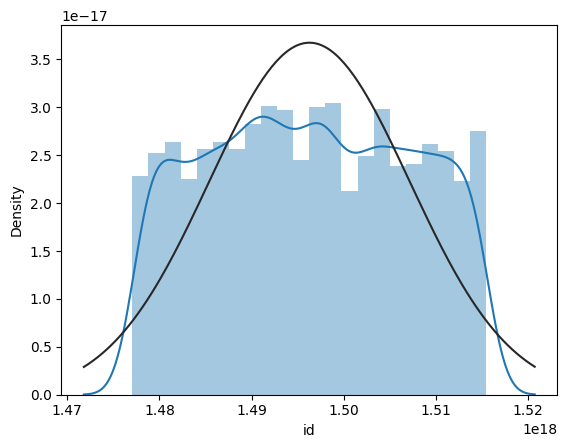

In [ ]:
# before log transformation
sns.distplot(original_data['id'], fit=norm);


<ipython-input-20-e311674dbc98>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['id'], fit=norm);


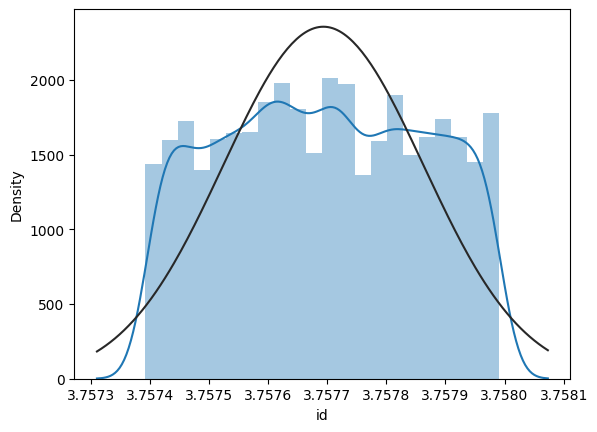

In [ ]:
# after log transformation
sns.distplot(data['id'], fit=norm);

<ipython-input-21-dfdb2dc94103>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data['retweet_count'], fit=norm);


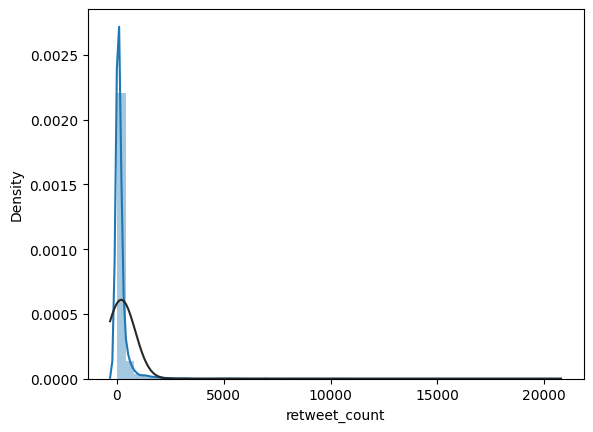

In [ ]:
# before log transformation
sns.distplot(original_data['retweet_count'], fit=norm);

<ipython-input-22-f56bef9f3503>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['retweet_count'], fit=norm);


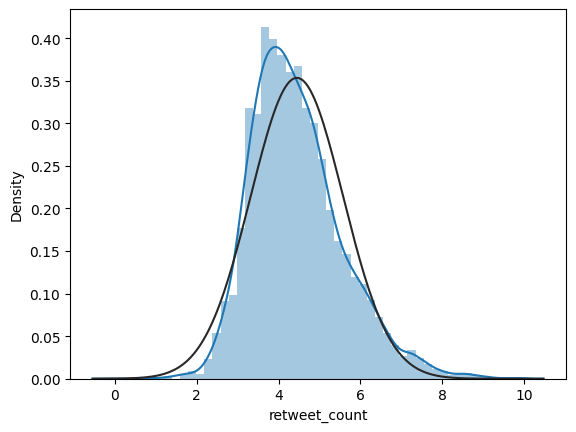

In [ ]:
# after log transformation
sns.distplot(data['retweet_count'], fit=norm);

<ipython-input-23-8036d6a2d00d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data['reply_count'], fit=norm);


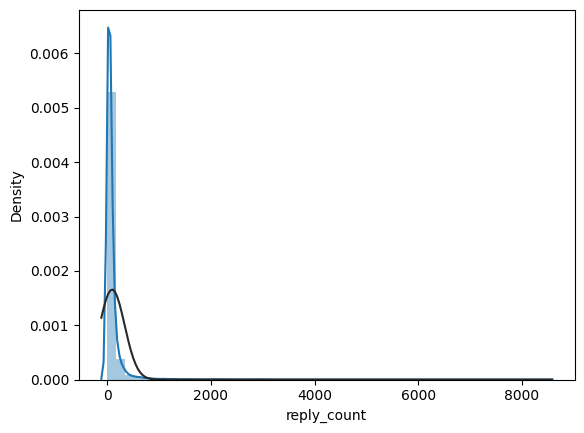

In [ ]:
# before log transformation
sns.distplot(original_data['reply_count'], fit=norm);

<ipython-input-24-2720e82f1edb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['reply_count'], fit=norm);


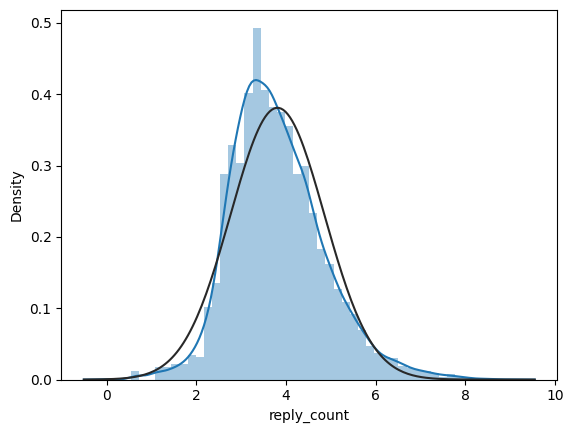

In [ ]:
# after log transformation
sns.distplot(data['reply_count'], fit=norm);

<ipython-input-25-882f3afa1052>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data['like_count'], fit=norm);


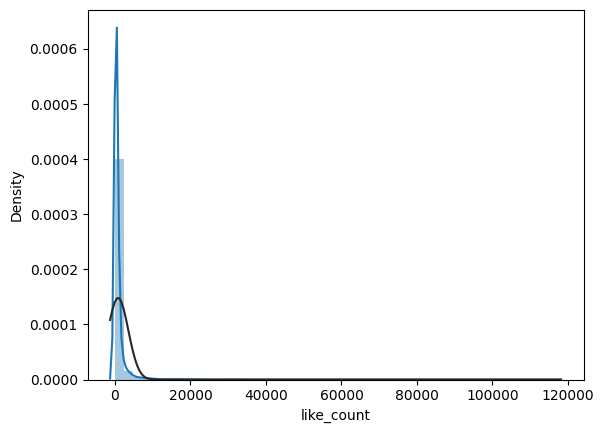

In [ ]:
# before log transformation
sns.distplot(original_data['like_count'], fit=norm);

<ipython-input-26-5c48d0d4dd47>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['like_count'], fit=norm);


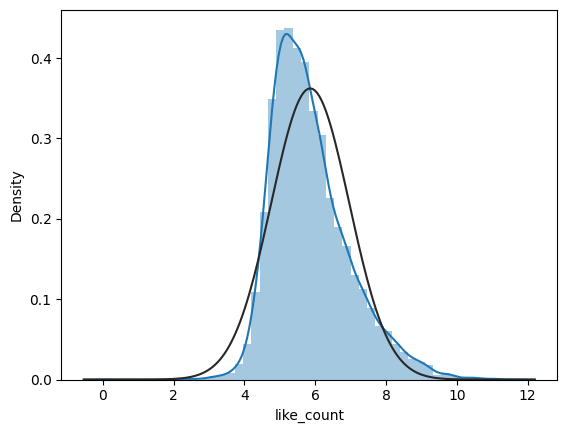

In [ ]:
# after log transformation
sns.distplot(data['like_count'], fit=norm);

In [ ]:
# Scale features using statistics that are robust to outliers.
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# scalled all the feature selections aside shares and populairty
scalled_data = scaler.fit_transform(data.iloc[:, :-2])

# update the dataframe back with the scalled data
data.iloc[:, :-2] = scalled_data

# the data after log transformation and robust scaler
data.describe()

data.iloc[:,:-2]

,id,retweet_count,reply_count
0,0.852091,1.639941,1.085270
1,-0.428536,-0.378304,-0.644425
2,0.783417,-0.765946,-0.644425
3,-0.690994,-0.176842,-0.416769
4,-0.891699,-0.105305,-0.058715
...,...,...,...
9095,0.347331,0.165349,0.365649
9096,-0.988240,-0.105305,-0.450247
9097,0.484907,0.423394,0.540624
9098,-0.124246,-0.635626,0.502960


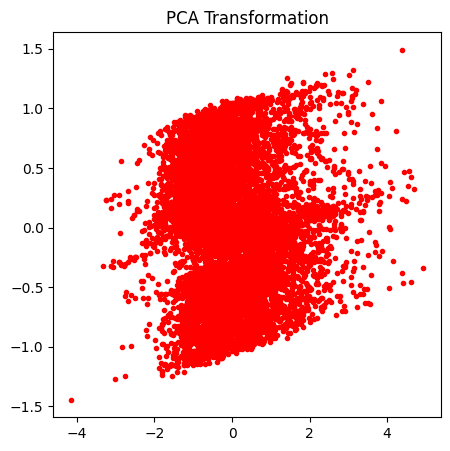

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data.iloc[:,:-2])
reduced_data.shape

# plotting the clusters PCA
plt.figure(figsize=(5,5))
plt.plot(reduced_data[:,0], reduced_data[:,1], 'r.')
plt.title('PCA Transformation')

plt.show()

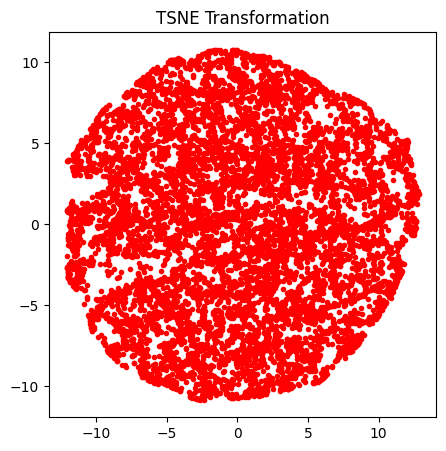

In [ ]:
tsne = TSNE(n_components=2, n_iter=300)
reduced_tsne = tsne.fit_transform(data.iloc[:,:-2])

# plotting the clusters TSNE
plt.figure(figsize=(5,5))
plt.plot(reduced_tsne[:,0], reduced_tsne[:,1], 'r.')
plt.title('TSNE Transformation')
plt.show()

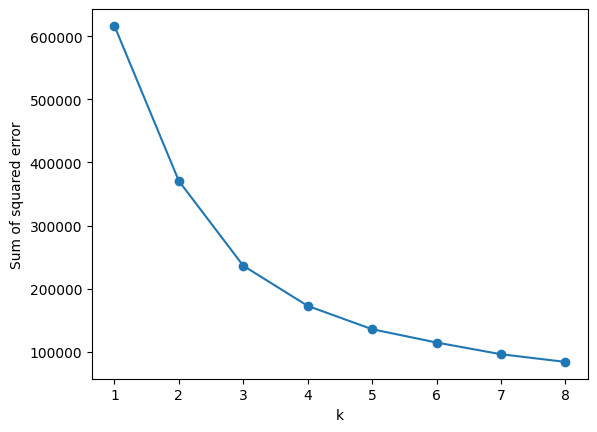

In [ ]:
from sklearn.cluster import KMeans
k=list(range(1,9))
ssd=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(reduced_tsne)
    ssd.append(kmeans.inertia_)

plt.plot(k,ssd,'o-')
plt.xlabel('k')
plt.ylabel('Sum of squared error')
plt.show()

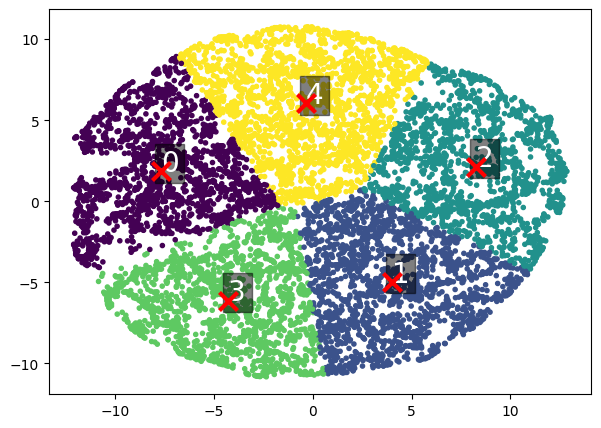

Centroids of the clusters: [[-7.6970167   1.8473514 ]
 [ 4.0016837  -4.967374  ]
 [ 8.243337    2.1421688 ]
 [-4.2834616  -6.1224465 ]
 [-0.34563416  6.0604076 ]]
Unique cluster labels: [0 1 2 3 4]


In [ ]:
# Predicts the clusters
kmeans=KMeans(init='k-means++',n_clusters=5)
kmeans.fit(reduced_tsne)
# Predict cluster labels for each data point
kmeans_preds=kmeans.predict(reduced_tsne)
# Retrieve centroids
centroids = kmeans.cluster_centers_
# Find unique clusters
clusters = np.unique(kmeans_preds)

# ploting the result of of the clusters
ax, fig = plt.subplots(figsize=(7,5))
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

# ploting the cluster numbers
for i in range(clusters.shape[0]):
    plt.text(centroids[i, 0], centroids[i, 1], clusters[i], fontsize=20, color='white',
             bbox=dict(facecolor='black', alpha=0.5))

plt.scatter(reduced_tsne[:,0],reduced_tsne[:,1],c=kmeans_preds,marker='.')
plt.show()
print("Centroids of the clusters:", centroids)
print("Unique cluster labels:", clusters)

In [ ]:
# fussing the cluster data into the dataframe
data1=pd.concat([data.reset_index(drop=True), pd.DataFrame(kmeans_preds, columns=['clusters'])],axis=1)

In [ ]:
data1.shape

(9100, 6)

In [ ]:
# extrating individual cluster from the data
cluster1_data = data1[data1['clusters'] == 0]
cluster2_data = data1[data1['clusters'] == 1]
cluster3_data = data1[data1['clusters'] == 2]
cluster4_data = data1[data1['clusters'] == 3]
cluster5_data = data1[data1['clusters'] == 4]
print ('Cluster1 size: ',cluster1_data.shape)
print ('Cluster2 size: ',cluster2_data.shape)
print ('Cluster3 size: ',cluster3_data.shape)
print ('Cluster4 size: ',cluster4_data.shape)
print ('Cluster5 size: ',cluster5_data.shape)

Cluster1 size:  (1769, 6)
Cluster2 size:  (1876, 6)
Cluster3 size:  (1712, 6)
Cluster4 size:  (1673, 6)
Cluster5 size:  (2070, 6)


<ipython-input-35-1e34ff15a42c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'F score for all Features - Cluster 1')

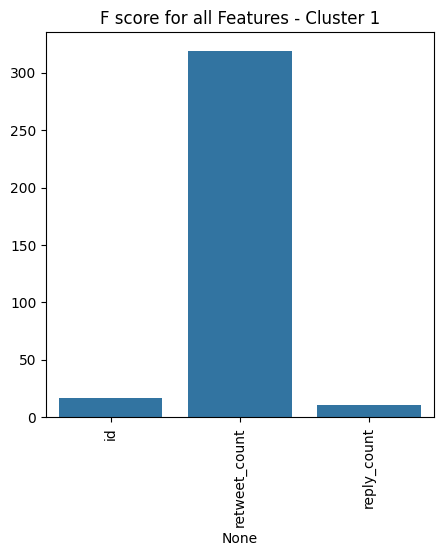

In [ ]:
from sklearn.feature_selection import f_classif
# F-Score for cluster 1
X1 = cluster1_data.iloc[:, :-3]
y1 = cluster1_data.iloc[:, -2]
f_test_data = f_classif(X1, y1)
f_score_1=f_test_data[0]

plt.figure(figsize=(5, 5))
g = sns.barplot(x=X1.columns,y=f_score_1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 1")

<ipython-input-36-82e01af6f81d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'F score for all Features - Cluster 2')

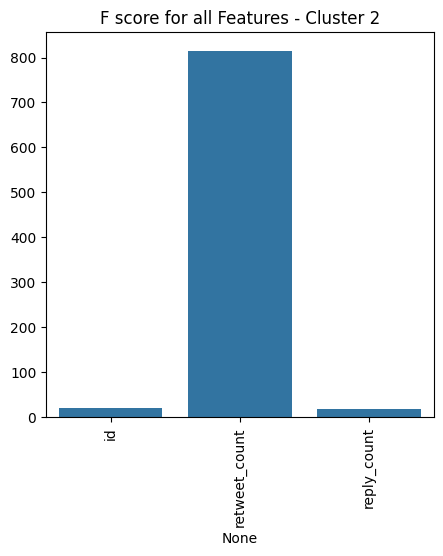

In [ ]:
# F-Score for cluster 2
X2 = cluster2_data.iloc[:, :-3]
y2 = cluster2_data.iloc[:, -2]
f_test_data = f_classif(X2, y2)
f_score_2=f_test_data[0]

plt.figure(figsize=(5, 5))
g = sns.barplot(x=X2.columns,y=f_score_2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 2")

<ipython-input-37-caf594d67a3c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'F score for all Features - Cluster 3')

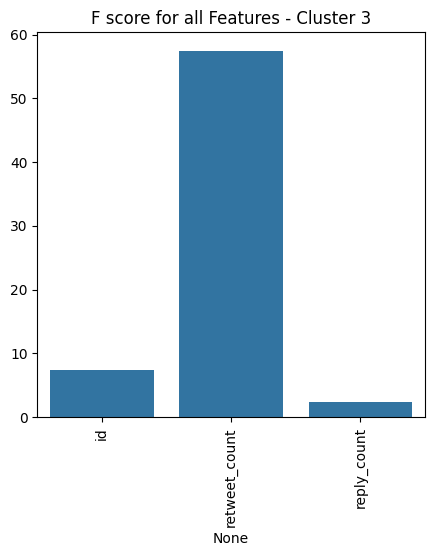

In [ ]:
# F-Score for cluster 3
X3 = cluster3_data.iloc[:, :-3]
y3 = cluster3_data.iloc[:, -2]
f_test_data = f_classif(X3, y3)
f_score_3=f_test_data[0]

plt.figure(figsize=(5, 5))
g = sns.barplot(x=X3.columns,y=f_score_3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 3")

In [ ]:
# F-Score for cluster 4
X4 = cluster4_data.iloc[:, :-3]
y4 = cluster4_data.iloc[:, -2]
f_test_data = f_classif(X4, y4)
f_score_4=f_test_data[0]

# F-Score for cluster 5
X5 = cluster5_data.iloc[:, :-3]
y5 = cluster5_data.iloc[:, -2]
f_test_data = f_classif(X5, y5)
f_score_5=f_test_data[0]

<ipython-input-39-861035bdd88c>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'F score for all Features - Cluster 4')

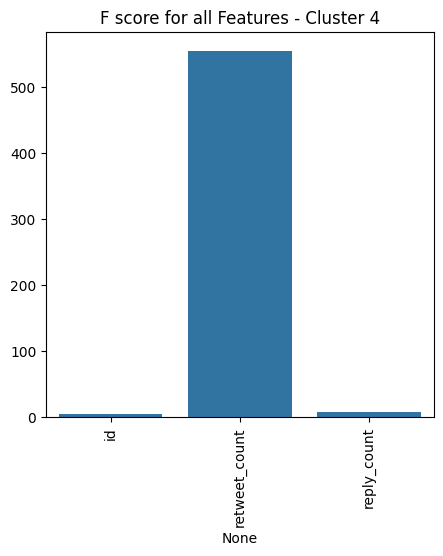

In [ ]:
plt.figure(figsize=(5, 5))
g = sns.barplot(x=X4.columns,y=f_score_4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 4")

<ipython-input-40-2e7a638deab8>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'F score for all Features - Cluster 5')

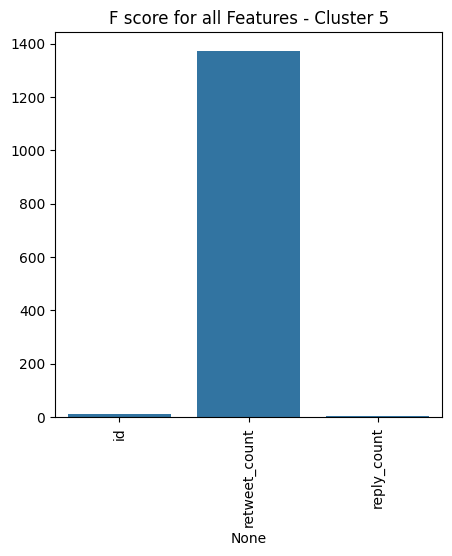

In [ ]:
plt.figure(figsize=(5, 5))
g = sns.barplot(x=X4.columns,y=f_score_5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("F score for all Features - Cluster 5")

In [ ]:
# an helper function for extracting the best features possible
def extract_best_features(feature_scores, feature_col, n=5, sort_metric=False):
    # this function extracts out the best features.
    # inputs
    temp = np.hstack((feature_scores.reshape(-1,1), feature_col.reshape(-1,1)))
    features = pd.DataFrame(temp, columns=['score', 'name'])
    # sort the features
    features = features.sort_values(by=['score'], ascending=sort_metric).reset_index(drop=True)
    # extract the best features
    best_features = features.iloc[:n, :].to_numpy()
    return best_features

In [ ]:
best_features = extract_best_features(f_score_1, X1.columns.values, n=10)
best_features

array([[319.28322659255315, 'retweet_count'],
       [16.59825189359223, 'id'],
       [10.261840486650058, 'reply_count']], dtype=object)

In [ ]:
# PCA for cluster 1
# for 1 features
transformer = PCA(n_components=1)
pca_clus1_1 = transformer.fit_transform(X1)
# for 2 features
transformer = PCA(n_components=2)
pca_clus1_2 = transformer.fit_transform(X1)
# for 3 features
transformer = PCA(n_components=3)
pca_clus1_3 = transformer.fit_transform(X1)

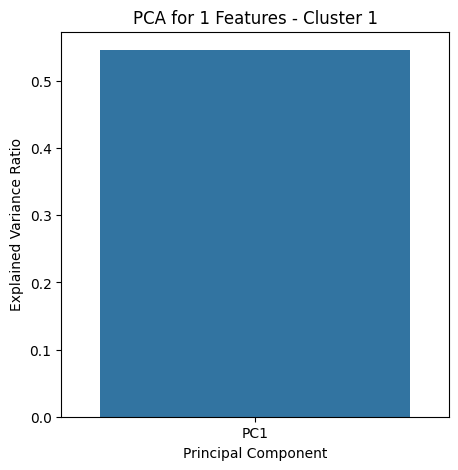

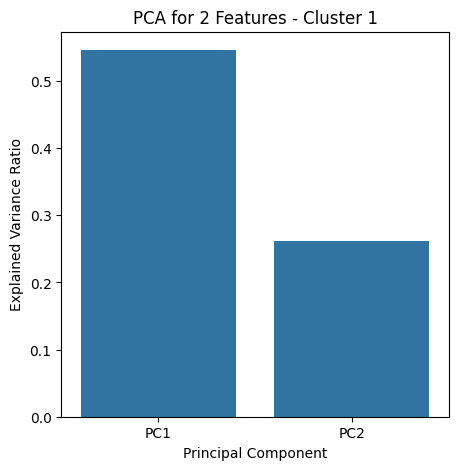

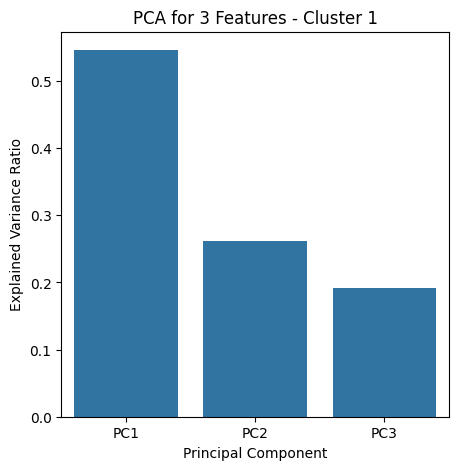

In [ ]:
# ploting the result of PCA
num_components = [1, 2, 3]

# Perform PCA and visualize the results
for n in num_components:
    # Perform PCA
    transformer = PCA(n_components=n)
    pca_result = transformer.fit_transform(X1)

    # Create a dataframe with PCA results
    pca_results_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n)])

    # Plot the explained variance ratio
    plt.figure(figsize=(5, 5))
    sns.barplot(x=pca_results_df.columns, y=transformer.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'PCA for {n} Features - Cluster 1')
    plt.show()

In [ ]:
# PCA for cluster 2
# for 1 features
transformer = PCA(n_components=1)
pca_clus2_1 = transformer.fit_transform(X2)
# for 2 features
transformer = PCA(n_components=2)
pca_clus2_2 = transformer.fit_transform(X2)
# for 3 features
transformer = PCA(n_components=3)
pca_clus2_3 = transformer.fit_transform(X2)

In [ ]:
# PCA for cluster 3
# for 1 features
transformer = PCA(n_components=1)
pca_clus3_1 = transformer.fit_transform(X3)
# for 2 features
transformer = PCA(n_components=2)
pca_clus3_2 = transformer.fit_transform(X3)
# for 3 features
transformer = PCA(n_components=3)
pca_clus3_3 = transformer.fit_transform(X3)

In [ ]:
# PCA for cluster 4
# for 1 features
transformer = PCA(n_components=1)
pca_clus4_1 = transformer.fit_transform(X4)
# for 2 features
transformer = PCA(n_components=2)
pca_clus4_2 = transformer.fit_transform(X4)
# for 3 features
transformer = PCA(n_components=3)
pca_clus4_3 = transformer.fit_transform(X4)

In [ ]:
# PCA for cluster 5
# for 1 features
transformer = PCA(n_components=1)
pca_clus5_1 = transformer.fit_transform(X5)
# for 2 features
transformer = PCA(n_components=2)
pca_clus5_2 = transformer.fit_transform(X5)
# for 3 features
transformer = PCA(n_components=3)
pca_clus5_3 = transformer.fit_transform(X5)

In [ ]:
# encoding the label set with a label encoder
from sklearn.preprocessing import LabelEncoder

labelEn = LabelEncoder()
encoded_labels = labelEn.fit_transform(y1.values)
class_names = labelEn.classes_
class_names

array(['Popular', 'Unpopular'], dtype=object)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Initialize label encoder
labelEn = LabelEncoder()

# Initialize an empty nested list to store accuracy, precision, and recall values
metrics_table = []

# Helper function to train and evaluate a KNN model and store metrics
def evaluate_cluster(pca_data, y, cluster_num):
    encoded_labels = labelEn.fit_transform(y.values)
    cluster_metrics = []  # Metrics values for the current cluster

    for i in range(len(pca_data)):
        X_train, X_test, y_train, y_test = train_test_split(pca_data[i], encoded_labels, test_size=0.3, shuffle=False)
        neigh = KNeighborsClassifier(n_neighbors=26, n_jobs=-1)
        neigh.fit(X_train, y_train)
        # Predict the result
        y_pred = neigh.predict(X_test)
        # Calculate accuracy, precision, and recall
        accuracy = 100 * accuracy_score(y_pred, y_test)
        precision = 100 * precision_score(y_test, y_pred, average='weighted')
        recall = 100 * recall_score(y_test, y_pred, average='weighted')
        # Append metrics to the cluster's metrics list
        cluster_metrics.append((accuracy, precision, recall))

    metrics_table.append(cluster_metrics)

# For Cluster 1
evaluate_cluster([pca_clus1_1, pca_clus1_2, pca_clus1_3], y1, 1)

# For Cluster 2
evaluate_cluster([pca_clus2_1, pca_clus2_2, pca_clus2_3], y2, 2)

# For Cluster 3
evaluate_cluster([pca_clus3_1, pca_clus3_2, pca_clus3_3], y3, 3)

# For Cluster 4
evaluate_cluster([pca_clus4_1, pca_clus4_2, pca_clus4_3], y4, 4)

# For Cluster 5
evaluate_cluster([pca_clus5_1, pca_clus5_2, pca_clus5_3], y5, 5)

# Print the metrics table in tabular format
print("KNN (PCA) \t1 Features\t\t\t\t\t\t\t2 Features\t\t\t\t\t\t\t3 Features")
print("Cluster\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall")
for i, cluster_metrics in enumerate(metrics_table):
    print(f"Cluster {i+1}\t"
          f"{cluster_metrics[0][0]:.2f}%\t\t{cluster_metrics[0][1]:.2f}%\t\t{cluster_metrics[0][2]:.2f}%\t\t"
          f"{cluster_metrics[1][0]:.2f}%\t\t{cluster_metrics[1][1]:.2f}%\t\t{cluster_metrics[1][2]:.2f}%\t\t"
          f"{cluster_metrics[2][0]:.2f}%\t\t{cluster_metrics[2][1]:.2f}%\t\t{cluster_metrics[2][2]:.2f}%")

KNN (PCA) 	1 Features							2 Features							3 Features
Cluster		Accuracy	Precision	Recall		Accuracy	Precision	Recall		Accuracy	Precision	Recall
Cluster 1	90.96%		87.57%		90.96%		91.90%		90.16%		91.90%		91.71%		89.95%		91.71%
Cluster 2	75.67%		64.91%		75.67%		83.66%		82.78%		83.66%		83.84%		82.96%		83.84%
Cluster 3	98.44%		96.91%		98.44%		98.44%		96.91%		98.44%		98.44%		96.91%		98.44%
Cluster 4	80.88%		73.80%		80.88%		87.05%		86.34%		87.05%		86.25%		85.05%		86.25%
Cluster 5	59.74%		59.48%		59.74%		76.81%		76.79%		76.81%		77.46%		77.46%		77.46%


Best k: 26
Best cross-validation accuracy: 0.88


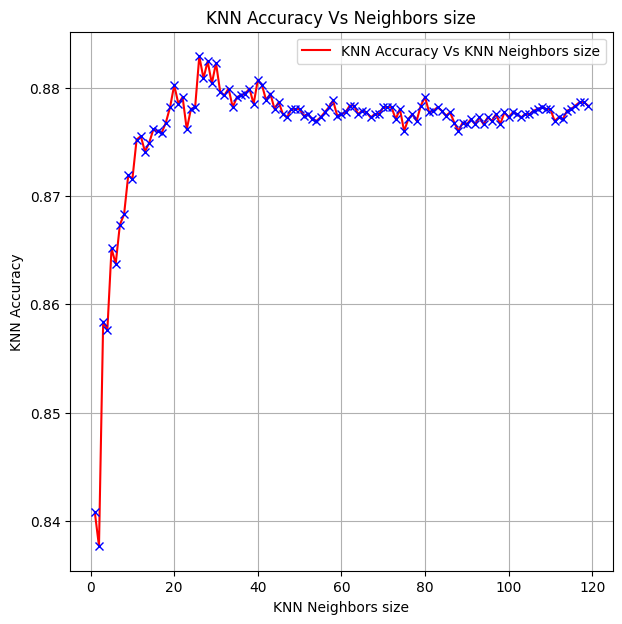

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
# Cross-validation for KNN
X = data1.iloc[:, :-3]  # Features
y = data1.iloc[:, -2]   # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# List of k values to test
k_range = np.arange(1, 120)

# Initialize a list to store cross-validation scores
cv_scores = []

# Perform cross-validation for each k value
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best k
best_k = k_range[np.argmax(cv_scores)]
best_cv_score = max(cv_scores)

print(f"Best k: {best_k}")
print(f"Best cross-validation accuracy: {best_cv_score:.2f}")

# Plot the cross-validation accuracy for each k
plt.figure(figsize=(7, 7))
plt.plot(k_range, cv_scores, 'r-', label='KNN Accuracy Vs KNN Neighbors size')
plt.plot(k_range, cv_scores, 'bx')
plt.xlabel('KNN Neighbors size')
plt.ylabel('KNN Accuracy')
plt.legend()
plt.grid()
plt.title('KNN Accuracy Vs Neighbors size')
plt.show()

In [ ]:
# Initialize an empty nested list to store metrics values
metrics_table = []

# Helper function to train and evaluate a KNN model and store metrics
def evaluate_cluster(X, y, f_score, cluster_num):
    encoded_labels = labelEn.fit_transform(y.values)
    features_list = ['1 Features', '2 Features', '3 Features']
    n_features = [1, 2, 3]
    cluster_metrics = []  # Metrics values for the current cluster

    for i in range(len(features_list)):
        best_features = extract_best_features(f_score, X.columns.values, n=n_features[i])
        # the features are stored in the second column
        drop_these = list(set(X.columns.values) - set(best_features[:, 1]))
        data_clus_fscore = X.drop(drop_these, axis=1, inplace=False)
        X_train, X_test, y_train, y_test = train_test_split(data_clus_fscore, encoded_labels, test_size=0.3, shuffle=False)
        neigh = KNeighborsClassifier(n_neighbors=26, n_jobs=-1)
        neigh.fit(X_train, y_train)
        # Predict the result
        y_pred = neigh.predict(X_test)
        # Calculate accuracy, precision, and recall
        accuracy = 100 * accuracy_score(y_pred, y_test)
        precision = 100 * precision_score(y_test, y_pred, average='weighted')
        recall = 100 * recall_score(y_test, y_pred, average='weighted')
        # Append metrics to the cluster's metrics list
        cluster_metrics.append((accuracy, precision, recall))

    metrics_table.append(cluster_metrics)

# For Cluster 1
evaluate_cluster(X1, y1, f_score_1, 1)

# For Cluster 2
evaluate_cluster(X2, y2, f_score_2, 2)

# For Cluster 3
evaluate_cluster(X3, y3, f_score_3, 3)

# For Cluster 4
evaluate_cluster(X4, y4, f_score_4, 4)

# For Cluster 5
evaluate_cluster(X5, y5, f_score_5, 5)

# Print the metrics table in tabular format
print("KNN (F-score) \t1 Features\t\t\t\t\t\t2 Features\t\t\t\t\t\t\t3 Features")
print("Cluster\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall")
for i, cluster_metrics in enumerate(metrics_table):
    print(f"Cluster {i+1}\t"
          f"{cluster_metrics[0][0]:.2f}%\t\t{cluster_metrics[0][1]:.2f}%\t\t{cluster_metrics[0][2]:.2f}%\t\t"
          f"{cluster_metrics[1][0]:.2f}%\t\t{cluster_metrics[1][1]:.2f}%\t\t{cluster_metrics[1][2]:.2f}%\t\t"
          f"{cluster_metrics[2][0]:.2f}%\t\t{cluster_metrics[2][1]:.2f}%\t\t{cluster_metrics[2][2]:.2f}%")


KNN (F-score) 	1 Features						2 Features							3 Features
Cluster		Accuracy	Precision	Recall		Accuracy	Precision	Recall		Accuracy	Precision	Recall
Cluster 1	91.53%		89.83%		91.53%		92.66%		91.45%		92.66%		91.71%		89.95%		91.71%
Cluster 2	85.79%		85.25%		85.79%		84.37%		83.53%		84.37%		83.84%		82.96%		83.84%
Cluster 3	98.44%		96.91%		98.44%		98.44%		96.91%		98.44%		98.44%		96.91%		98.44%
Cluster 4	86.06%		85.40%		86.06%		87.25%		86.52%		87.25%		86.25%		85.05%		86.25%
Cluster 5	78.26%		78.30%		78.26%		78.26%		78.25%		78.26%		77.46%		77.46%		77.46%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize an empty nested list to store metrics values
metrics_table = []

# Helper function to train and evaluate a Random Forest model and store metrics
def evaluate_cluster(X, y, cluster_num):
    encoded_labels = labelEn.fit_transform(y.values)
    features_list = ['1 Features', '2 Features', '3 Features']
    n_estimators = 200
    max_depth = 50
    random_state = 0
    cluster_metrics = []  # Metrics values for the current cluster

    for i in range(len(features_list)):
        pca_data = X[i]
        X_train, X_test, y_train, y_test = train_test_split(pca_data, encoded_labels, test_size=0.3, shuffle=False, random_state=42)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        clf.fit(X_train, y_train)
        # Predict the result
        y_pred = clf.predict(X_test)
        # Calculate accuracy, precision, and recall
        accuracy = 100 * accuracy_score(y_pred, y_test)
        precision = 100 * precision_score(y_test, y_pred, average='weighted')
        recall = 100 * recall_score(y_test, y_pred, average='weighted')
        # Append metrics to the cluster's metrics list
        cluster_metrics.append((accuracy, precision, recall))

    metrics_table.append(cluster_metrics)

# For Cluster 1
evaluate_cluster([pca_clus1_1, pca_clus1_2, pca_clus1_3], y1, 1)

# For Cluster 2
evaluate_cluster([pca_clus2_1, pca_clus2_2, pca_clus2_3], y2, 2)

# For Cluster 3
evaluate_cluster([pca_clus3_1, pca_clus3_2, pca_clus3_3], y3, 3)

# For Cluster 4
evaluate_cluster([pca_clus4_1, pca_clus4_2, pca_clus4_3], y4, 4)

# For Cluster 5
evaluate_cluster([pca_clus5_1, pca_clus5_2, pca_clus5_3], y5, 5)

# Print the metrics table in tabular format
print("RF(PCA)\t\t1 Features\t\t\t\t\t\t \t2 Features\t\t\t\t\t\t \t3 Features")
print("Cluster\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall")
for i, cluster_metrics in enumerate(metrics_table):
    print(f"Cluster {i+1}\t"
          f"{cluster_metrics[0][0]:.2f}%\t\t{cluster_metrics[0][1]:.2f}%\t\t{cluster_metrics[0][2]:.2f}%\t\t"
          f"{cluster_metrics[1][0]:.2f}%\t\t{cluster_metrics[1][1]:.2f}%\t\t{cluster_metrics[1][2]:.2f}%\t\t"
          f"{cluster_metrics[2][0]:.2f}%\t\t{cluster_metrics[2][1]:.2f}%\t\t{cluster_metrics[2][2]:.2f}%")


RF(PCA)		1 Features						 	2 Features						 	3 Features
Cluster		Accuracy	Precision	Recall		Accuracy	Precision	Recall		Accuracy	Precision	Recall
Cluster 1	85.50%		87.17%		85.50%		90.40%		88.99%		90.40%		90.58%		88.75%		90.58%
Cluster 2	72.82%		71.51%		72.82%		82.24%		81.41%		82.24%		84.37%		83.66%		84.37%
Cluster 3	97.47%		96.90%		97.47%		98.25%		96.91%		98.25%		98.25%		96.91%		98.25%
Cluster 4	76.10%		76.10%		76.10%		85.46%		84.34%		85.46%		85.86%		84.37%		85.86%
Cluster 5	56.20%		55.96%		56.20%		73.91%		73.87%		73.91%		78.42%		78.40%		78.42%


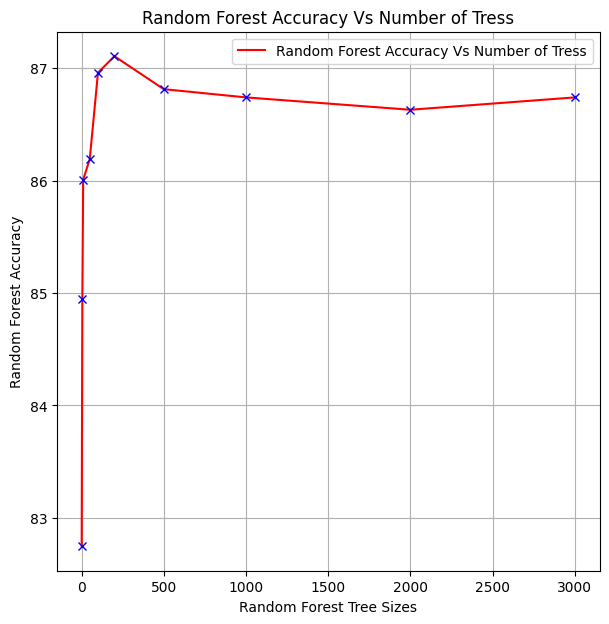

In [ ]:
# Cross validation For Random Forest
nns = [1, 5, 10, 50, 100, 200, 500, 1000, 2000, 3000]
accuracy = []
for n in nns:
    clf = RandomForestClassifier(n_estimators=n, n_jobs=5, max_depth=50,
                                 random_state=0)
    clf.fit(X_train, y_train)
    # predict the result
    y_pred = clf.predict(X_test)
    accuracy.append(100*accuracy_score(y_pred, y_test))
plt.figure(figsize=(7,7))
plt.plot(nns, accuracy, 'r-', label='Random Forest Accuracy Vs Number of Tress')
plt.plot(nns, accuracy, 'bx')
plt.xlabel('Random Forest Tree Sizes')
plt.ylabel('Random Forest Accuracy')
plt.legend()
plt.grid()
plt.title('Random Forest Accuracy Vs Number of Tress')
plt.show()

In [ ]:
# Initialize an empty nested list to store metrics values
metrics_table = []

# Helper function to train and evaluate a Random Forest model and store metrics
def evaluate_cluster(X, y, cluster_num):
    encoded_labels = labelEn.fit_transform(y.values)
    features_list = ['1 Features', '2 Features', '3 Features']
    n_estimators = 200
    max_depth = 50
    random_state = 0
    n_features = [1, 2, 3]
    cluster_metrics = []  # Metrics values for the current cluster

    for i in range(len(features_list)):
        best_features = extract_best_features(f_score_1, X.columns.values, n=n_features[i])
        # the features are stored in the second column
        drop_these = list(set(X.columns.values) - set(best_features[:, 1]))
        data_clus_fscore = X.drop(drop_these, axis=1, inplace=False)
        X_train, X_test, y_train, y_test = train_test_split(data_clus_fscore, encoded_labels, test_size=0.3, shuffle=False, random_state=42)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        clf.fit(X_train, y_train)
        # Predict the result
        y_pred = clf.predict(X_test)
        # Calculate accuracy, precision, and recall
        accuracy = 100 * accuracy_score(y_pred, y_test)
        precision = 100 * precision_score(y_test, y_pred, average='weighted')
        recall = 100 * recall_score(y_test, y_pred, average='weighted')
        # Append metrics to the cluster's metrics list
        cluster_metrics.append((accuracy, precision, recall))

    metrics_table.append(cluster_metrics)

# For Cluster 1
evaluate_cluster(X1, y1, 1)

# For Cluster 2
evaluate_cluster(X2, y2, 2)

# For Cluster 3
evaluate_cluster(X3, y3, 3)

# For Cluster 4
evaluate_cluster(X4, y4, 4)

# For Cluster 5
evaluate_cluster(X5, y5, 5)

# Print the metrics table in tabular format
print("RF (F-Score)\t1 Features\t\t\t\t\t\t2 Features\t\t\t\t\t\t3 Features")
print("Cluster\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall")
for i, cluster_metrics in enumerate(metrics_table):
    print(f"Cluster {i+1}\t"
          f"{cluster_metrics[0][0]:.2f}%\t\t{cluster_metrics[0][1]:.2f}%\t\t{cluster_metrics[0][2]:.2f}%\t\t"
          f"{cluster_metrics[1][0]:.2f}%\t\t{cluster_metrics[1][1]:.2f}%\t\t{cluster_metrics[1][2]:.2f}%\t\t"
          f"{cluster_metrics[2][0]:.2f}%\t\t{cluster_metrics[2][1]:.2f}%\t\t{cluster_metrics[2][2]:.2f}%")


RF (F-Score)	1 Features						2 Features						3 Features
Cluster		Accuracy	Precision	Recall		Accuracy	Precision	Recall		Accuracy	Precision	Recall
Cluster 1	90.96%		89.09%		90.96%		91.34%		89.92%		91.34%		91.15%		89.13%		91.15%
Cluster 2	84.37%		83.52%		84.37%		81.88%		80.91%		81.88%		83.66%		82.85%		83.66%
Cluster 3	98.05%		97.48%		98.05%		98.25%		96.91%		98.25%		98.44%		96.91%		98.44%
Cluster 4	85.66%		84.16%		85.66%		83.86%		82.65%		83.86%		86.85%		86.01%		86.85%
Cluster 5	76.81%		76.87%		76.81%		72.79%		72.74%		72.79%		77.62%		77.60%		77.62%


In [ ]:
from sklearn.svm import SVC
metrics_table = []

# Helper function to train and evaluate a SVM model and store metrics
def evaluate_cluster(X, y, cluster_num):
    encoded_labels = labelEn.fit_transform(y.values)
    features_list = ['1 Features', '2 Features', '3 Features']
    cluster_metrics = []  # Metrics values for the current cluster
    pca_data = [pca_clus1_1, pca_clus1_2, pca_clus1_3]

    for i in range(len(features_list)):
        X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.3, shuffle=False)
        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)
        # Predict the result
        y_pred = clf.predict(X_test)
        # Calculate accuracy, precision, and recall
        accuracy = 100 * accuracy_score(y_pred, y_test)
        precision = 100 * precision_score(y_test, y_pred, average='weighted')
        recall = 100 * recall_score(y_test, y_pred, average='weighted')
        # Append metrics to the cluster's metrics list
        cluster_metrics.append((accuracy, precision, recall))

    metrics_table.append(cluster_metrics)

# For Cluster 1
evaluate_cluster(pca_clus1_1, y1, 1)

# For Cluster 2
evaluate_cluster(pca_clus2_1, y2, 2)

# For Cluster 3
evaluate_cluster(pca_clus3_1, y3, 3)

# For Cluster 4
evaluate_cluster(pca_clus4_1, y4, 4)

# For Cluster 5
evaluate_cluster(pca_clus5_1, y5, 5)

# Print the metrics table in tabular format
print("SVM (PCA)\t1 Features\t\t\t\t\t\t \t2 Features\t\t\t\t\t\t \t3 Features")
print("Cluster\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall")
for i, cluster_metrics in enumerate(metrics_table):
    print(f"Cluster {i+1}\t"
          f"{cluster_metrics[0][0]:.2f}%\t\t{cluster_metrics[1][0]:.2f}%\t\t{cluster_metrics[2][0]:.2f}%\t\t"
          f"{cluster_metrics[0][1]:.2f}%\t\t{cluster_metrics[1][1]:.2f}%\t\t{cluster_metrics[2][1]:.2f}%\t\t"
          f"{cluster_metrics[0][2]:.2f}%\t\t{cluster_metrics[1][2]:.2f}%\t\t{cluster_metrics[2][2]:.2f}%")

SVM (PCA)	1 Features						 	2 Features						 	3 Features
Cluster		Accuracy	Precision	Recall		Accuracy	Precision	Recall		Accuracy	Precision	Recall
Cluster 1	91.15%		91.15%		91.15%		83.08%		83.08%		83.08%		91.15%		91.15%		91.15%
Cluster 2	76.20%		76.20%		76.20%		58.06%		58.06%		58.06%		76.20%		76.20%		76.20%
Cluster 3	98.44%		98.44%		98.44%		96.91%		96.91%		96.91%		98.44%		98.44%		98.44%
Cluster 4	82.07%		82.07%		82.07%		67.36%		67.36%		67.36%		82.07%		82.07%		82.07%
Cluster 5	61.84%		61.84%		61.84%		61.91%		61.91%		61.91%		61.84%		61.84%		61.84%


Cross-validation accuracy: 0.88


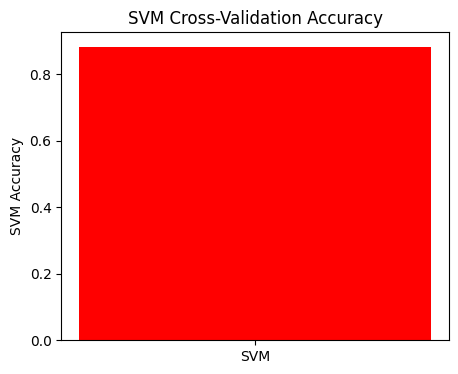

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

# Prepare data
X = data1.iloc[:, :-3]  # Features
y = data1.iloc[:, -2]   # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize a list to store cross-validation scores
cv_scores = []

# Perform cross-validation
clf = SVC(gamma='auto')
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores.append(scores.mean())

# Print the cross-validation results
print(f"Cross-validation accuracy: {cv_scores[0]:.2f}")

# Plot the cross-validation accuracy
plt.figure(figsize=(5, 4))
plt.bar(['SVM'], cv_scores, color='r')
plt.ylabel('SVM Accuracy')
plt.title('SVM Cross-Validation Accuracy')
plt.show()


In [ ]:
# Initialize an empty nested list to store metrics values
metrics_table = []

# Helper function to train and evaluate a SVM model and store metrics
def evaluate_cluster(X, y, cluster_num):
    encoded_labels = labelEn.fit_transform(y.values)
    features_list = ['1 Features', '2 Features', '3 Features']
    n_features = [1, 2, 3]
    cluster_metrics = []  # Metrics values for the current cluster

    for i in range(len(features_list)):
        best_features = extract_best_features(f_score_1, X.columns.values, n=n_features[i])
        # the features are stored in the second column
        drop_these = list(set(X.columns.values) - set(best_features[:, 1]))
        data_clus_fscore = X.drop(drop_these, axis=1, inplace=False)
        X_train, X_test, y_train, y_test = train_test_split(data_clus_fscore, encoded_labels, test_size=0.3, shuffle=False)
        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)
        # Predict the result
        y_pred = clf.predict(X_test)
        # Calculate accuracy, precision, and recall
        accuracy = 100 * accuracy_score(y_pred, y_test)
        precision = 100 * precision_score(y_test, y_pred, average='weighted')
        recall = 100 * recall_score(y_test, y_pred, average='weighted')
        # Append metrics to the cluster's metrics list
        cluster_metrics.append((accuracy, precision, recall))

    metrics_table.append(cluster_metrics)

# For Cluster 1
evaluate_cluster(X1, y1, 1)

# For Cluster 2
evaluate_cluster(X2, y2, 2)

# For Cluster 3
evaluate_cluster(X3, y3, 3)

# For Cluster 4
evaluate_cluster(X4, y4, 4)

# For Cluster 5
evaluate_cluster(X5, y5, 5)

# Print the metrics table in tabular format
print("SVM (F-Score)\t1 Features\t\t\t\t\t \t2 Features\t\t\t\t\t\t3 Features")
print("Cluster\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall\t\tAccuracy\tPrecision\tRecall")
for i, cluster_metrics in enumerate(metrics_table):
    print(f"Cluster {i+1}\t"
          f"{cluster_metrics[0][0]:.2f}%\t\t{cluster_metrics[1][0]:.2f}%\t\t{cluster_metrics[2][0]:.2f}%\t\t"
          f"{cluster_metrics[0][1]:.2f}%\t\t{cluster_metrics[1][1]:.2f}%\t\t{cluster_metrics[2][1]:.2f}%\t\t"
          f"{cluster_metrics[0][2]:.2f}%\t\t{cluster_metrics[1][2]:.2f}%\t\t{cluster_metrics[2][2]:.2f}%")


SVM (F-Score)	1 Features					 	2 Features						3 Features
Cluster		Accuracy	Precision	Recall		Accuracy	Precision	Recall		Accuracy	Precision	Recall
Cluster 1	90.96%		91.34%		91.15%		86.89%		92.09%		83.08%		90.96%		91.34%		91.15%
Cluster 2	83.66%		85.08%		85.44%		82.88%		84.92%		84.86%		83.66%		85.08%		85.44%
Cluster 3	98.44%		98.44%		98.44%		96.91%		96.91%		96.91%		98.44%		98.44%		98.44%
Cluster 4	86.06%		85.66%		85.66%		84.67%		84.13%		84.17%		86.06%		85.66%		85.66%
Cluster 5	78.74%		78.74%		78.42%		78.83%		78.81%		78.41%		78.74%		78.74%		78.42%
